In [ ]:
!pip install numpy==1.24.3
!pip install pmdarima==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go


#💾 Data Load
Load data and use parse_dates to make date column datetime

In [ ]:
df=pd.read_csv("/content/sample_data/Electric_Production.csv", parse_dates=['DATE'])
df = df.asfreq('MS')
df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


## 📉Dataset Overview
This dataset contains monthly electricity production data in the U.S. over time. It is structured in a time series format, where each row corresponds to one month.
Note: The column IPG2211A2N is the Federal Reserve Economic Data (FRED) code for electric production. For analysis or visualization, here its renamed as EP for simplicity.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


##📊 Data Information
The dataset contains 397 entries, each representing monthly electricity production data starting from January 1985.

There are no missing values

In [ ]:
df['time_interval']= df['DATE']-df['DATE'].shift(1)


In [ ]:
df['time_interval'].value_counts()

,count
time_interval,
31 days,231
30 days,132
28 days,25
29 days,8


So the data in monthly distributed

In [ ]:
df.drop('time_interval', axis=1, inplace=True)
df.rename(columns={'IPG2211A2N':'EP'}, inplace = True)
df.head()

,DATE,EP
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


##📊Data Exploration through Visualisation
Now lets explore data with visual analysis

1.   DATA wrt time
2.   seasonal_decompose
3.   Monthly plot
4. if needed Quarterly plot




In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=df['DATE'], y=df['EP'], mode='lines'))
fig.update_layout(
    title="Electric Production Company Data",
    xaxis_title="Date",
    yaxis_title="Electric Production",
)
fig.show()

from figure it seems that data have both seasonality and trend
So now we will check monthly seasonality diagram

In [ ]:
df.set_index('DATE',inplace=True)

<ipython-input-81-87dd253d9b60>:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



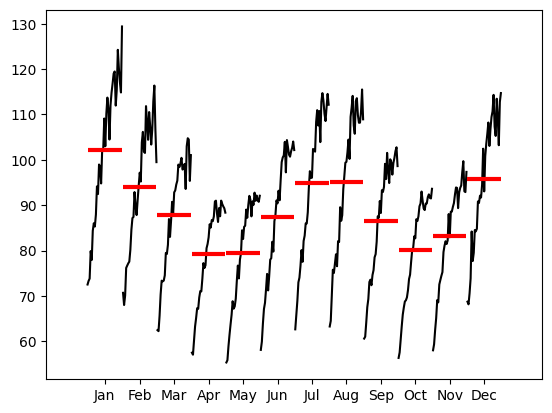

In [ ]:
#Month plot to check seasonality
month_plot(df['EP'].resample('M').mean())
plt.show()

<ipython-input-12-b9206b343ac9>:1: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



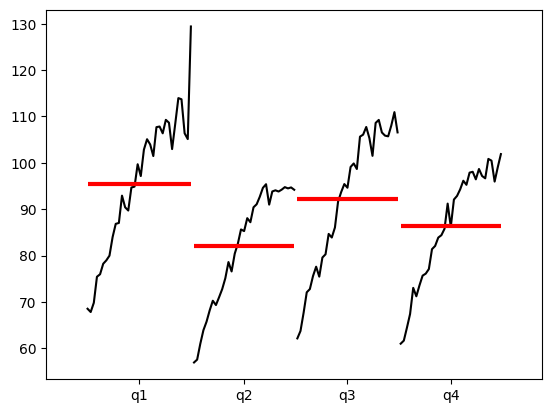

In [ ]:
#Quarter Plot
quarter_plot(df['EP'].resample('Q').mean())
plt.show()

✅ Notes: so first and third quarter are high withh maximum required in jan


###📊 Seasonal Decompose

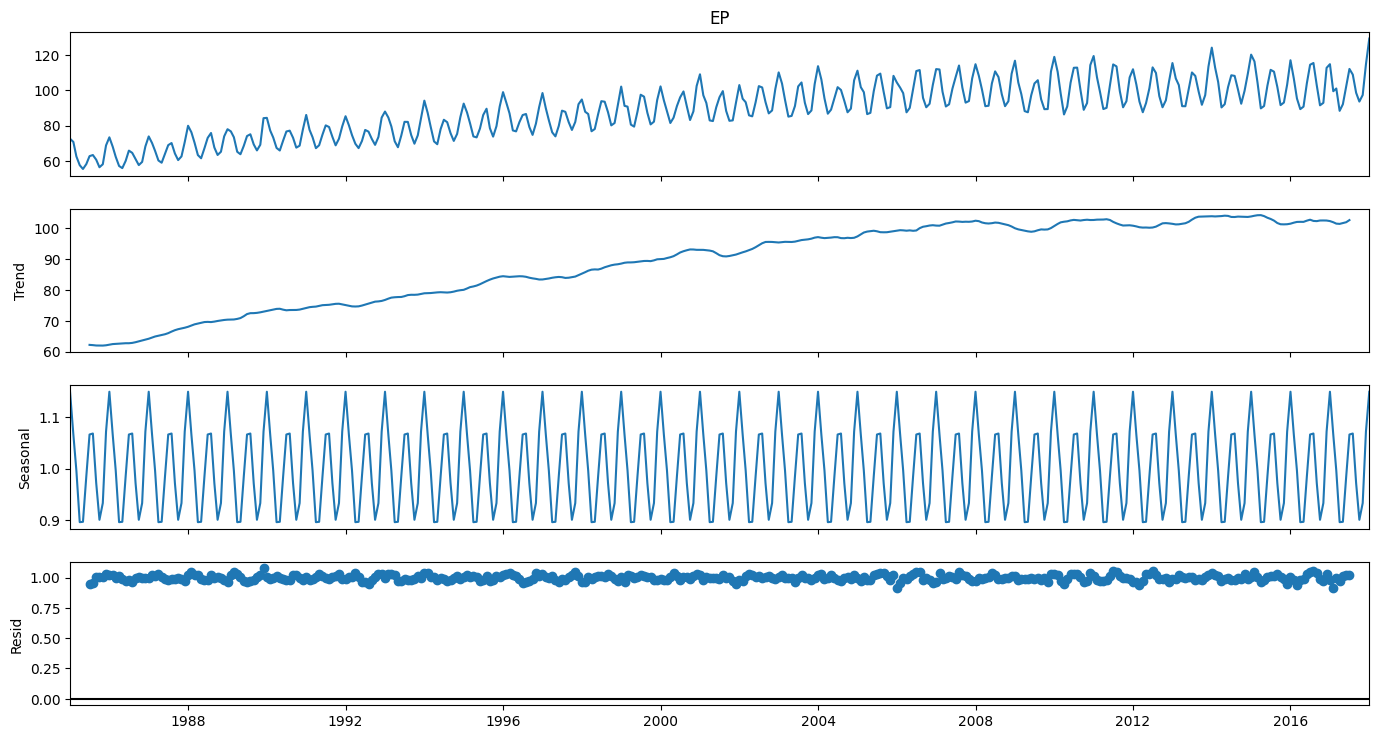

In [ ]:
decomposition=seasonal_decompose(df['EP'],
                                 model='mul',
                                 period=12)

fig=decomposition.plot()
fig.set_size_inches(15,8)
plt.show()

##📈 Check Stationarity
1. Visualisation
2. Partition
3. Adfuller test

In [ ]:
# Visualisation of data and its rolling mean and standard deviation

df['rolling_mean']= df['EP'].rolling(window=12).mean()
df['rolling_std']= df['EP'].rolling(window=12).std()
fig=go.Figure([
    go.Scatter(x=df.index, y=df['EP'], mode='lines', name='EP'),
    go.Scatter(x=df.index, y=df['rolling_mean'], mode='lines', name='EP_rolling_mean'),
    go.Scatter(x=df.index, y=df['rolling_std'], mode='lines', name='EP_rolling_std')
    ])

fig.update_layout(
    title="Electric Production Company Data",
    xaxis_title="Date",
    yaxis_title="Electric Production",
)
fig.show()

In [ ]:
#Adfuller Test
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['EP'])
adf_stat = result[0]
p_val = result[1]
print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_val}")

ADF Statistic: -2.256990350047225
p-value: 0.1862146911658744


In [ ]:
# Check stationarity through partition
length = len(df['EP'])
half = length//2
partition1M = df['EP'].head(half).mean()
partition2M = df['EP'].tail(half).mean()
partition1S = df['EP'].head(half).std()
partition2S = df['EP'].tail(half).std()
print(partition1M, partition2M,partition1S, partition2S)

77.40359141414143 100.25434494949495 11.04946873556601 9.550627487225432


✅ Observation on Stationarity

🔹 Visualisation:The mean of the series changes over time, indicating that the data is not stationary. A stationary time series should have a constant mean and variance

🔹 Adfuller test shows p_value is >0.5, indicating non-stationary data

🔹 Stationarity check through also indicate different mean and std value so non-stationary data.

##ACF and PACF Plot

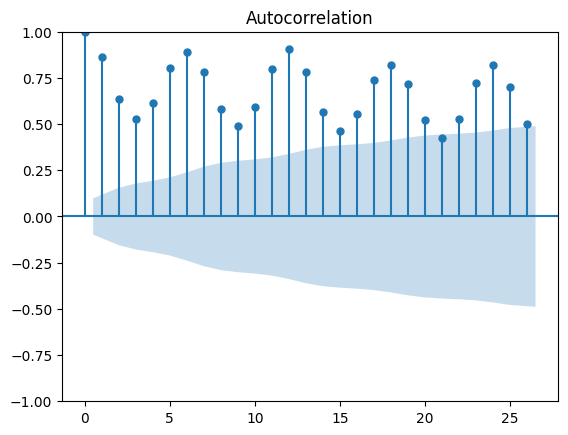

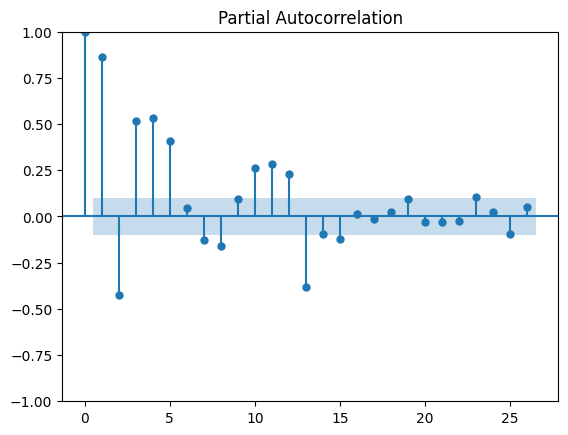

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['EP'])
plt.show()
plot_pacf(df['EP'])
plt.show()

In [ ]:
#Differencing to remove non-stationarity through trend
diff1=np.diff(df['EP'])
df['EP_DIFF']=np.append([0],diff1)

In [ ]:
diff2=np.diff(df['EP_DIFF'])
df['EP_DIFF2']=np.append([0],diff2)

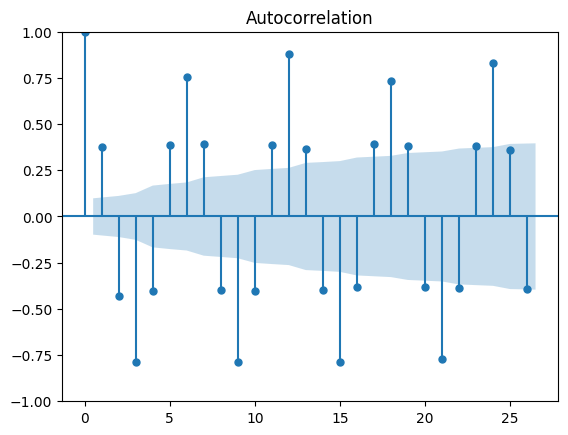

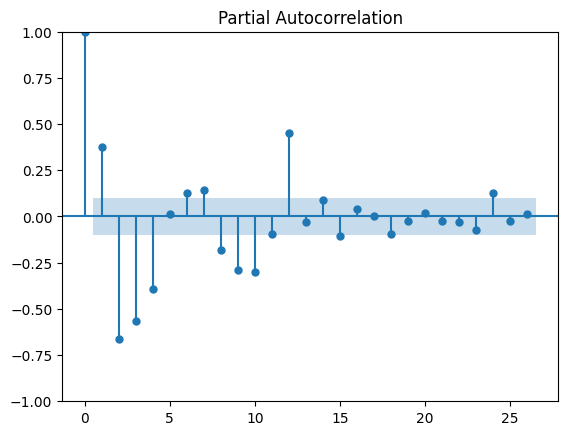

In [ ]:
plot_acf(df['EP_DIFF'])
plt.show()
plot_pacf(df['EP_DIFF'])
plt.show()

🔹 Even after differencing, the data remains non-stationary, and the plots indicate strong seasonality.

🔹 Therefore, I will apply seasonal differencing or other techniques to remove seasonality and achieve stationarity before modeling.

In [ ]:
#Seasobnal Differencing
df['EP_S']=df['EP']-df['EP'].shift(12)
diffS=np.diff(df['EP_S'])
df['EP_DIFFS']=np.append([0],diffS)

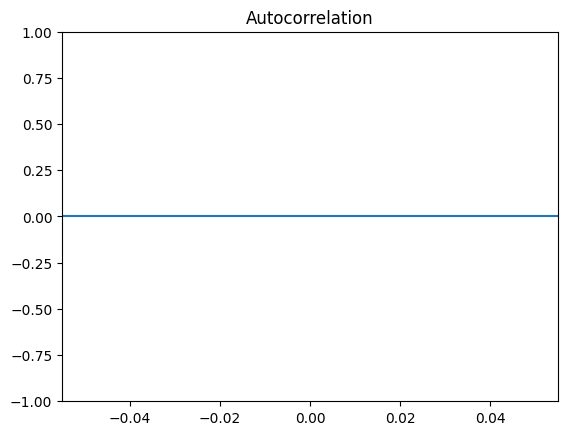

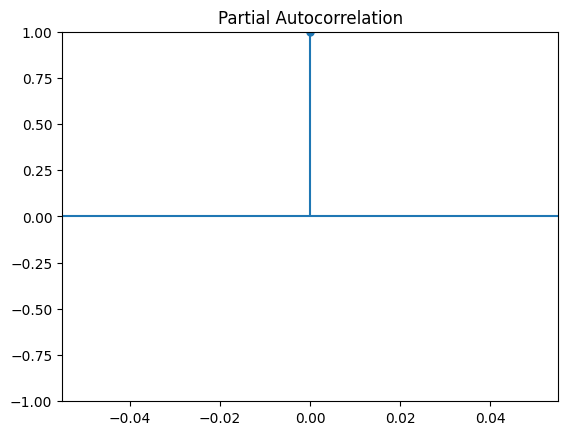

In [ ]:
plot_acf(df['EP_DIFFS'])
plt.show()
plot_pacf(df['EP_DIFFS'])
plt.show()

In [ ]:
results=adfuller(df['EP_DIFFS'].dropna())
adf_stats = results[0]
p_vals = results[1]
print(f"ADF Statistic: {adf_stats}")
print(f"p-value: {p_vals}")

ADF Statistic: -8.029332164974067
p-value: 1.9777208722006325e-12


🔹 After applying seasonal differencing, the data became stationary.

🔹 This is confirmed by the ACF and PACF plots, which show no significant spikes, indicating the removal of seasonality and stabilization of the series.

🔹 Checked the same through adfuller test

Notes:
To make the data stationary, we applied:

First-order differencing to remove trend

Seasonal differencing to remove seasonality

In [ ]:
train, test=df.iloc[:-24,0], df.iloc[-24:,0]

In [ ]:
model = ExponentialSmoothing(train,
                             trend='add',
                             seasonal='mul',
                             seasonal_periods=12).fit()
prediction = model.forecast(30)

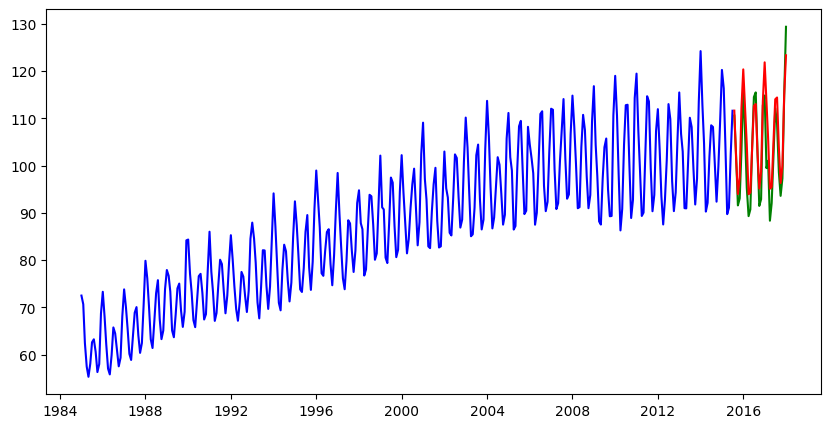

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train, color='blue', label='Train')
plt.plot(test, color='green', label='Test')
plt.plot(prediction, color='red', label='Prediction')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mae=mean_absolute_error(test, prediction)
mse=mean_squared_error(test,prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(test, prediction)
print(f'MAE:{mae:2f}')
print(f'MSE:{rmse:2f}')
print(f'MAPE:{mape:2%}')

MAE:4.064904
MSE:5.069043
MAPE:4.041989%


# ⚒️ SARIMA Model

In [ ]:
from pmdarima import auto_arima
model_sarima=auto_arima(train,
                        m=12,
                        trace=True)
model_sarima.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2521.235, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2186.836, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2519.309, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2400.531, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1738.984, Time=2.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1843.881, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1739.319, Time=4.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1738.452, Time=5.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2102.646, Time=1.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=5.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1759.518, Time=3.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=1762.781, Time=5.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=4.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1751.961, Time=5.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=14.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,2)[12]             : AIC=1736.456, Time=2.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,2)[12]             : AIC=2100.682, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,1)[12]             : AIC=1736.987, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,2)[12]             : AIC=inf, Time=7.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,1)[12]             : AIC=2184.885, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,1)[12]             : AIC=1737.297, Time=1.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,2)[12]             : AIC=1757.521, Time=1.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,2)[12]             : AIC=1760.733, Time=4.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,2)[12]             : AIC=1681.811, Time=4.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,2)[12]             : AIC=1986.088, Time=1.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,1)[12]             : AIC=1682.539, Time=0.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(2,0,2)[12]             : AIC=1681.708, Time=5.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(2,0,1)[12]             : AIC=1682.627, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(2,0,2)[12]             : AIC=inf, Time=7.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(2,0,2)[12]             : AIC=1676.011, Time=8.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(1,0,2)[12]             : AIC=1676.924, Time=4.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(2,0,1)[12]             : AIC=1677.815, Time=2.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(1,0,1)[12]             : AIC=1677.642, Time=1.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(2,0,2)[12]             : AIC=1676.406, Time=8.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(2,0,2)[12]             : AIC=1677.302, Time=7.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,4)(2,0,2)[12]             : AIC=1678.863, Time=9.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(2,0,2)[12] intercept   : AIC=inf, Time=8.52 sec

Best model:  ARIMA(0,1,3)(2,0,2)[12]          
Total fit time: 151.215 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  367
Model:             SARIMAX(0, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood                -830.005
Date:                                 Wed, 21 May 2025   AIC                           1676.011
Time:                                         18:59:24   BIC                           1707.232
Sample:                                     01-01-1985   HQIC                          1688.417
                                          - 07-01-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3739      0.050     -7.416      0.000      -0.473      -0.275
ma.L2         -0.3936      0.051     -7.751      0.000      -0.493      -0.294
ma.L3         -0.1350      0.052     -2.606      0.009      -0.236      -0.033
ar.S.L12       0.5053      0.329      1.537      0.124      -0.139       1.150
ar.S.L24       0.4873      0.325      1.498      0.134      -0.150       1.125
ma.S.L12      -0.1611      0.322     -0.501      0.617      -0.792       0.469
ma.S.L24      -0.4608      0.215     -2.145      0.032      -0.882      -0.040
sigma2         5.0008      0.336     14.886      0.000       4.342       5.659
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                18.38
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction_s=model_sarima.predict(30)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
mae=mean_absolute_error(test, prediction_s)
mse=mean_squared_error(test,prediction_s)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(test, prediction_s)
print(f'MAE:{mae:2f}')
print(f'MSE:{rmse:2f}')
print(f'MAPE:{mape:2%}')

MAE:3.550605
MSE:4.542613
MAPE:3.481481%


## 🧑🏻‍🔧 SARIMA Manual Improvement


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,
                order=(1, 1, 3),
                seasonal_order=(2, 1, 3, 12))
results = model.fit()
forecast = results.forecast(24)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
mae=mean_absolute_error(test, forecast)
mse=mean_squared_error(test,forecast)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(test, forecast)
print(f'MAE:{mae:2f}')
print(f'MSE:{rmse:2f}')
print(f'MAPE:{mape:2%}')

MAE:2.685489
MSE:3.776188
MAPE:2.509601%


In [ ]:
import plotly.graph_objects as go

fig = go.Figure([
    go.Scatter(x=train.index, y=train, mode='lines', line=dict(color='blue'), name='Train'),
    go.Scatter(x=test.index, y=test, mode='lines', line=dict(color='green'), name='Test'),
    go.Scatter(x=forecast.index, y=forecast, mode='lines', line=dict(color='red'), name='Forecast')
])

fig.update_layout(
    title="Electric Production Company Data",
    xaxis_title="Date",
    yaxis_title="Electric Production",
)
fig.show()

✅ Manual SARIMA Tuning Improved Forecast Accuracy

Auto-ARIMA suggested: SARIMAX(0, 1, 3)(2, 0, 2, 12)

→ MAPE: 3.48%

Based on ACF/PACF & seasonal differencing check, I manually used:
SARIMAX(1, 1, 3)(2, 1, 3, 12)

→ MAPE improved to: 2.50%

Auto-ARIMA is useful for getting a baseline model quickly. However, it may miss seasonal patterns if they aren't strong. In this case, manually setting seasonal differencing to D=1 based on domain knowledge and ADF test results gave better forecast accuracy (lower MAE, RMSE, MAPE).

Conclusion: Always validate Auto-ARIMA’s suggestions against ACF/PACF plots, stationarity checks, and your understanding of the data
